Студент: Абдулин Тимур

Когорта: DS_25 Plus

Login: tbetterknow@mail.ru 

**МАСТЕРСКАЯ 2: Сопоставление и поиск (мэтчинг) похожих товаров маркетплейса**

Описание задачи:

**Дано:**
- Два множества объектов: A и B. Каждый объект в множества описывается какими-то признаками.

**Желаемый результат:**
- Для каждого объекта из множества A найти один или несколько объектов из B, которые близки к нему по некоторой заданной метрике.
- A и B могут быть одним и тем же множеством ** Можем и не найти ни одного соответствия

**Исходные данные:**
- base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base, …) и вектор признаков размерностью 72.

- train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

- validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

- validation_answer.csv - правильные ответы к предыдущему файлу.

**Задача:**

- Разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

- Оценить качество алгоритма по метрике accuracy@5

**Итоги проекта:**
- Репозиторий на GitHub

- README

- Jupyter Notebook c решением

**Этапы выполнения проекта:**
1. Загрузка требуемых библиотек
2. Чтение данных
3. Исследовательский анализ данных (EDA)
4. Подготовка данных
5. Поиск ближайших соседей с помощью библиотеки FAISS
6. Обучение модели и расчет метрики accuracy@5

## Загрузка требуемых библиотек

In [1]:
# Загружаем трубуемые библиотеки для нашей работы
import faiss
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from tqdm import tqdm

In [2]:
# Указываем константы для проекта
RANDOM_STATE = 42  # Устанавливаем параметр случайности
N_CLUSTERS = 200 # Устанавливаем количество кластеров для деления векторного пространства
K_NEIGHBORS = 100 # Указываем количество ближайших соседей
N_CELLS = 5   # Указываем количество кандидатов для мэтчинга

## Чтение данных

In [3]:
# Читаем датасеты и записываем в переменные
base_df = pd.read_csv('/Users/tbetterknow/Desktop/Яндекс_Практикум/Мастерская 2 MATCHING/data/base.csv')
train_df = pd.read_csv('/Users/tbetterknow/Desktop/Яндекс_Практикум/Мастерская 2 MATCHING/data/train.csv')
valid_df = pd.read_csv('/Users/tbetterknow/Desktop/Яндекс_Практикум/Мастерская 2 MATCHING/data/validation.csv')
valid_targets = pd.read_csv('/Users/tbetterknow/Desktop/Яндекс_Практикум/Мастерская 2 MATCHING/data/validation_answer.csv')

In [4]:
# Производим смену индексации и приводим название полей к ежиному формату
for df in [base_df, train_df, valid_df, valid_targets]:
    df.columns = df.columns.str.lower()
    df.set_index('id', inplace=True)

# Оптимизируем память сменой типа данных с float64 на float32
for df in [base_df, train_df, valid_df, valid_targets]:
    float64_columns = df.select_dtypes(include=['float64']).columns
    for column in float64_columns:
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')

In [5]:
# Смотрим на первые строки датасета base_df
base_df.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


In [6]:
# Смотрим на первые строки датасета train_df
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,target
id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,...,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,...,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,...,45.028912,-196.092072,-117.626335,66.926224,42.456169,77.621765,92.479927,-1074.464844,-21.149351,717819-base


In [7]:
# Смотрим на первые строки датасета valid_df
valid_df.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,...,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,...,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604
100003-query,-99.286858,16.123936,9.837166,-148.060440,83.697083,-133.729721,58.576405,-19.046659,115.042404,75.206734,...,-77.236107,44.100494,-132.530121,-106.318985,70.883957,23.577892,133.183960,143.252945,-799.363647,-89.392670
100004-query,-79.532921,-0.364173,-16.027431,-170.884949,165.453918,-28.291668,33.931934,34.411217,128.903976,102.086914,...,-123.770248,45.635944,-134.258926,13.735359,70.617630,15.332115,154.568115,101.700638,-1171.892334,-125.307892


In [8]:
# Смотрим на первые строки датасета valid_targets
valid_targets.head()

,expected
id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [9]:
# Изучаем данные датасета base_df с помощью функции info()
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


In [10]:
# Изучаем данные датасета train_df с помощью функции info()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21  21  

In [11]:
# Изучаем данные датасета valid_df с помощью функции info()
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

In [12]:
# Изучаем данные датасета valid_targets с помощью функции info()
valid_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [13]:
# Смотрим на размерность датасетов функцией shape
print(base_df.shape)
print(train_df.shape)
print(valid_df.shape)
print(valid_targets.shape)

(2918139, 72)
(100000, 73)
(100000, 72)
(100000, 1)


In [14]:
# Проверяем данные на наличие пропусков и дубликатов
# Создадим функцию для вывода обоих показателей
def nas_duplicates(data):
    print("Количество пропусков:         ", data.isna().sum().sum())
    print("Дубликаты:   ", data.duplicated().sum())

In [15]:
# Выводим значения пропусков и дубликатов в датасете base_df
nas_duplicates(base_df)

Количество пропусков:          0
Дубликаты:    0


In [16]:
# Выводим значения пропусков и дубликатов в датасете train_df
nas_duplicates(train_df)

Количество пропусков:          0
Дубликаты:    0


In [17]:
# Выводим значения пропусков и дубликатов в датасете valid_df
nas_duplicates(valid_df)

Количество пропусков:          0
Дубликаты:    0


**Вывод по разделу 2: Чтение данных**

1. В нашем распоряжении 4 набора данных, включая 

- base_df (2918139 строк и 72 поля), 

- train_df (100000 строк, 73 поля, включая поле 'target'), 

- valid_df (100000 строк, 72 поля), 

- valid_targets (100000 строк, 1 поле 'expected').


2. Мы изменили тип данных с float64 на float32 для оптимизации ресурсов, а также привели поля к одному формату и изменили индексацию, чтобы поле id у нас было индексом в каждом датасете.

3. Также была проведена проверка данных на наличие пропусков и дубликатов в данных. Как результат ничего не обнаружено.


Следующим шагом переходим к исследовательскому анализу данных (EDA).

## Исследовательский анализ данных  (EDA)

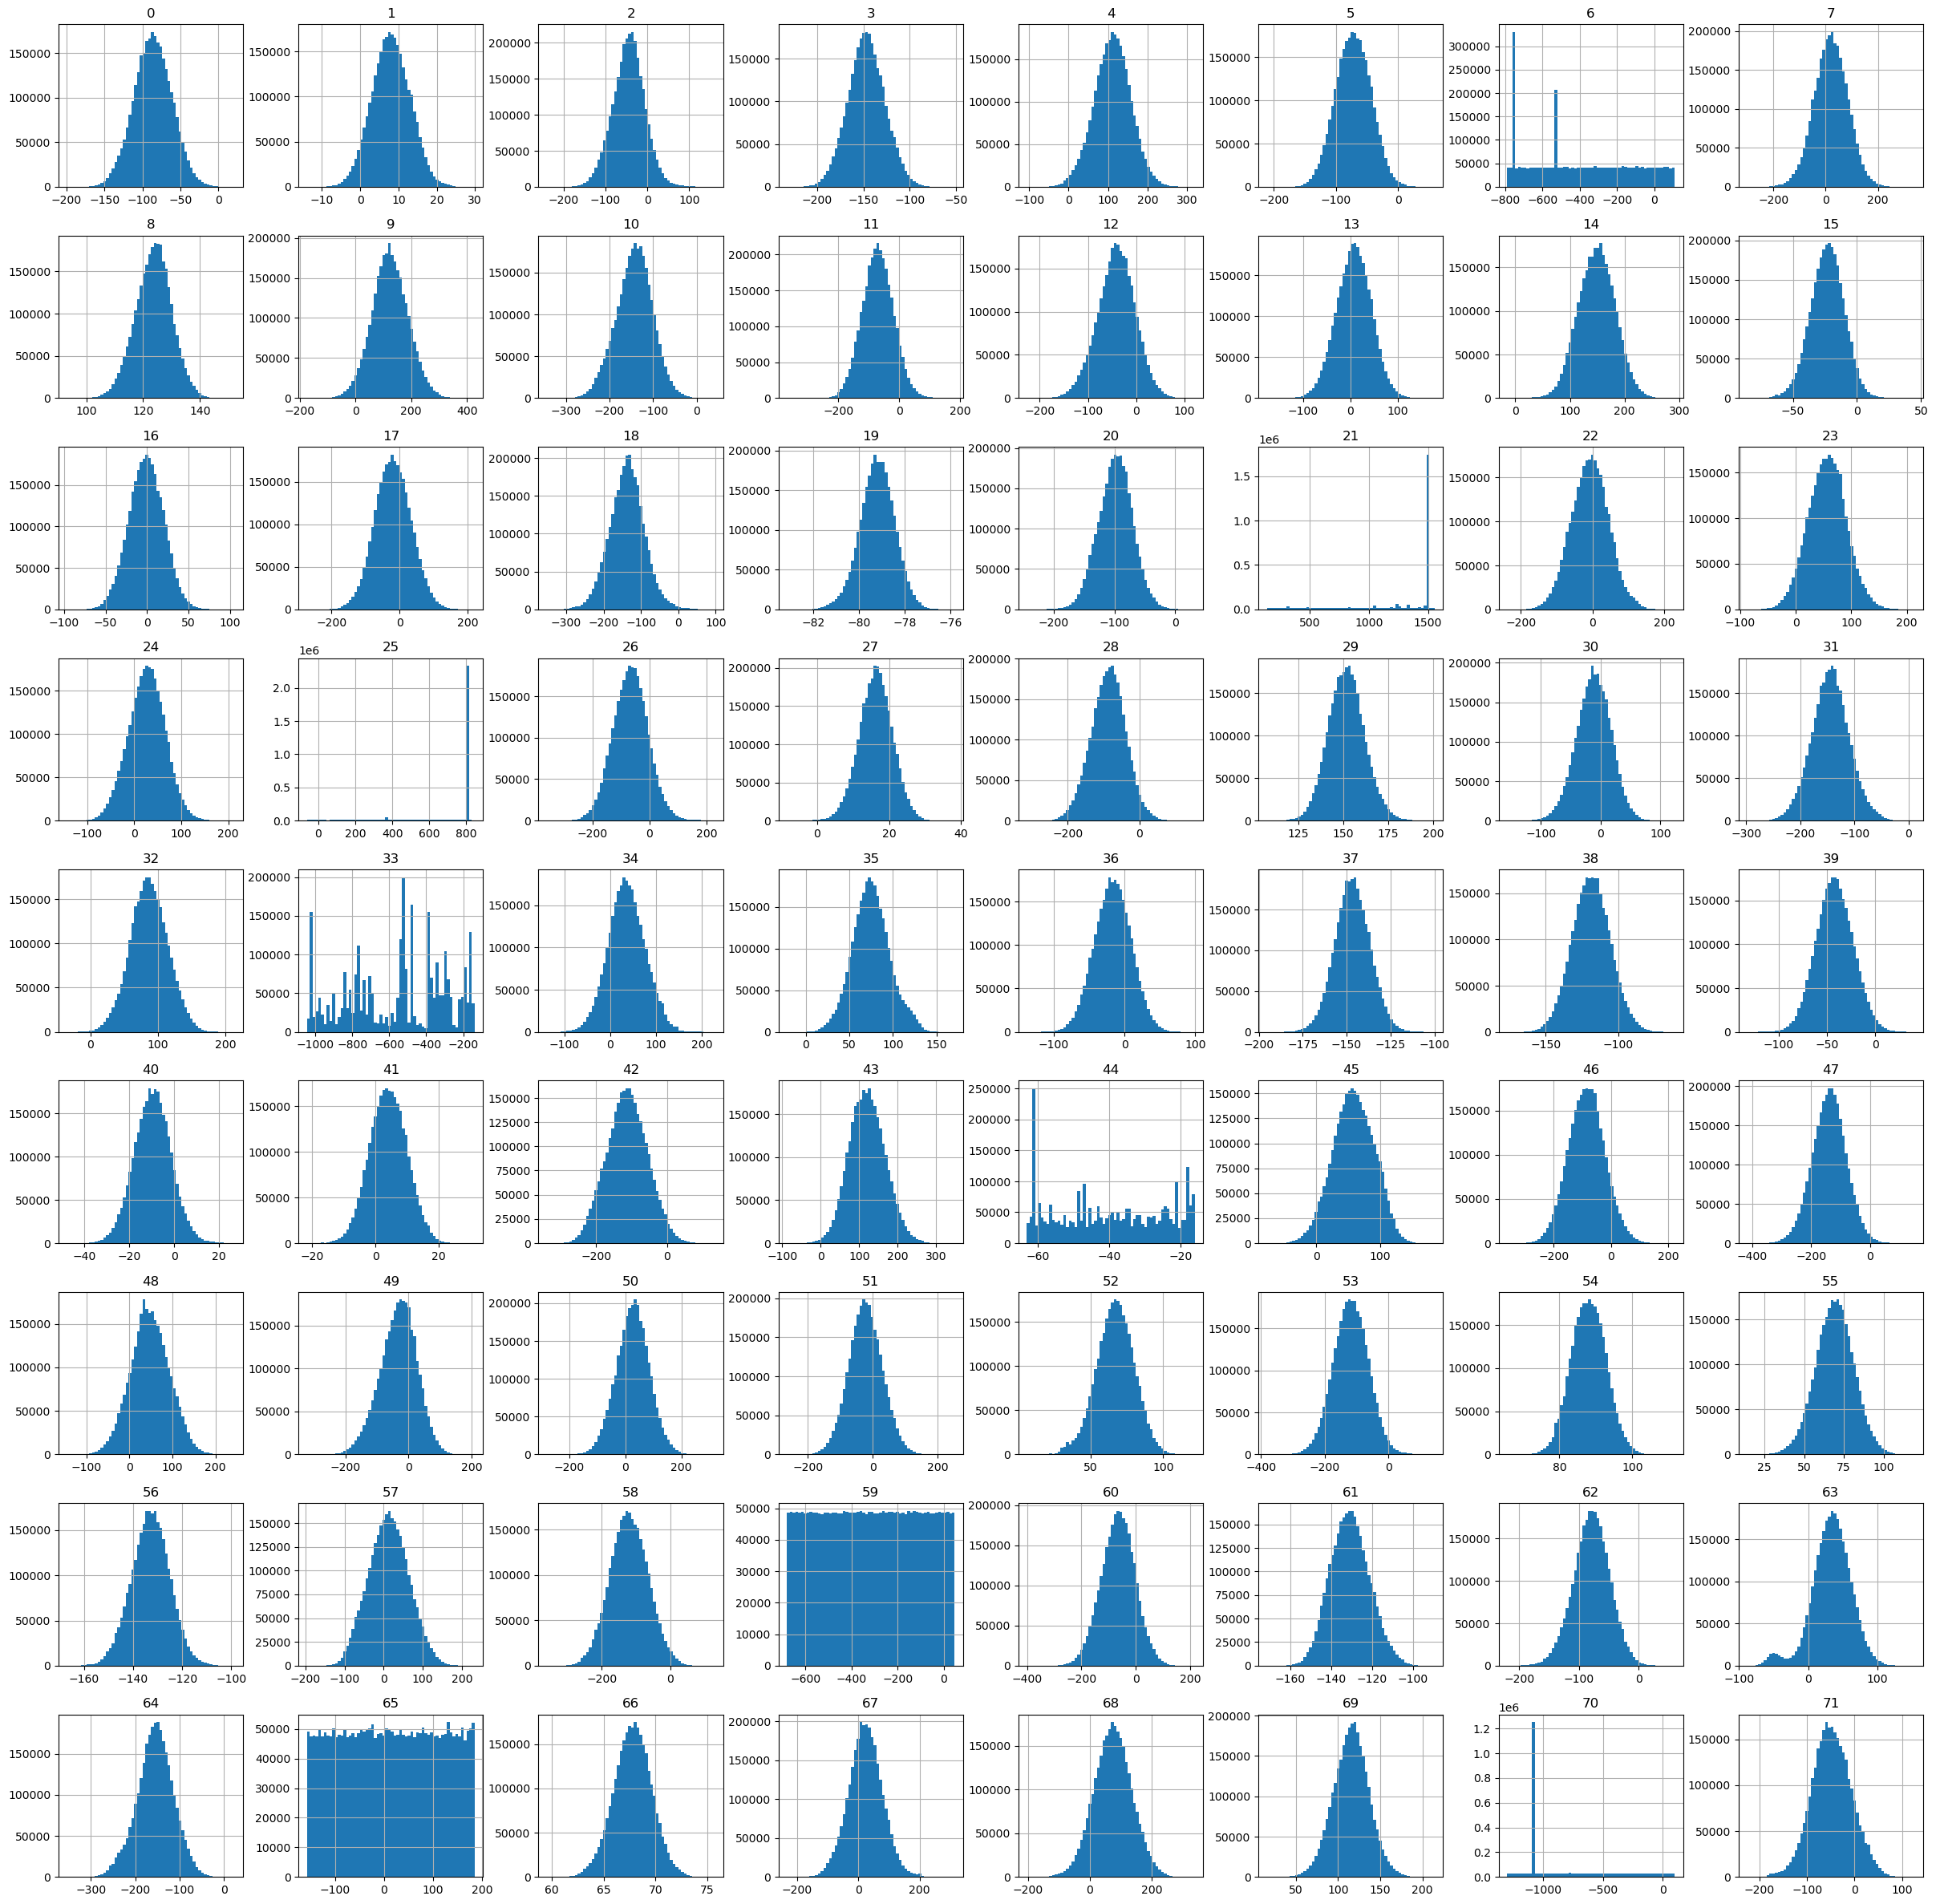

In [18]:
# Смотрим на распределение всех признаков датасета base_df
base_df.hist(figsize=[30, 30], bins=60);

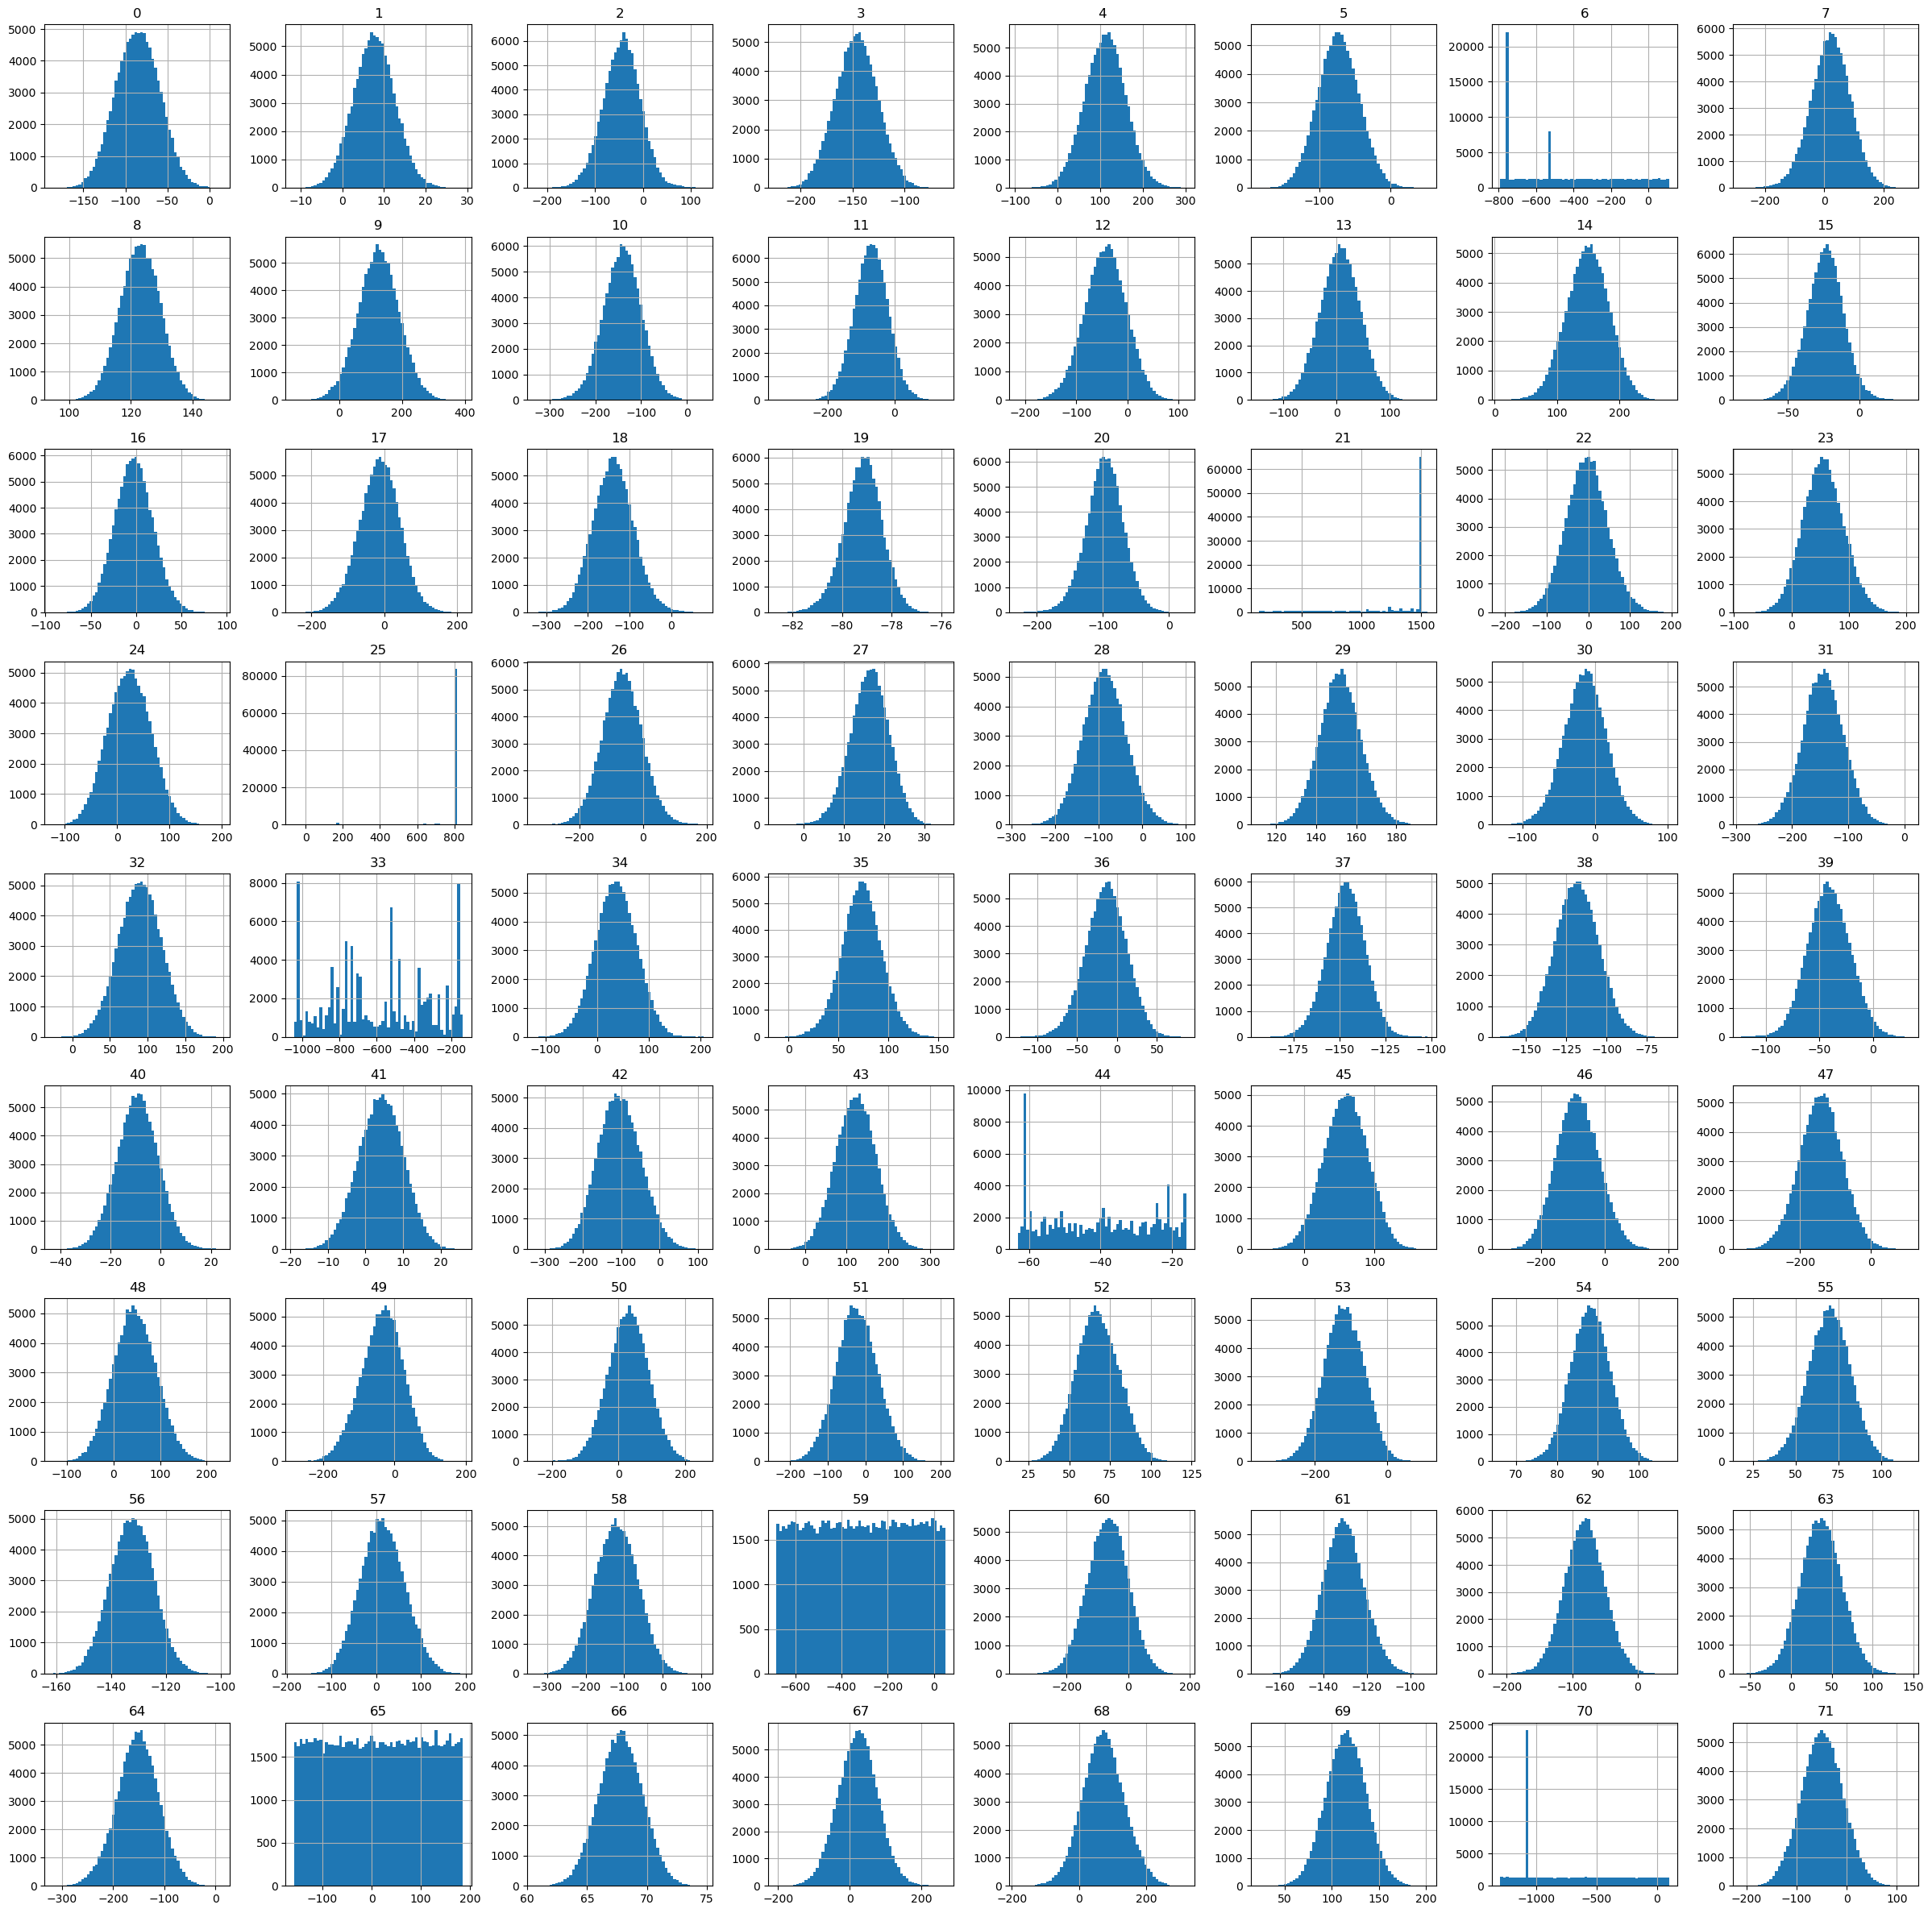

In [19]:
# Смотрим на распределение всех признаков датасета train_df
train_df.hist(figsize=[30, 30], bins=60);

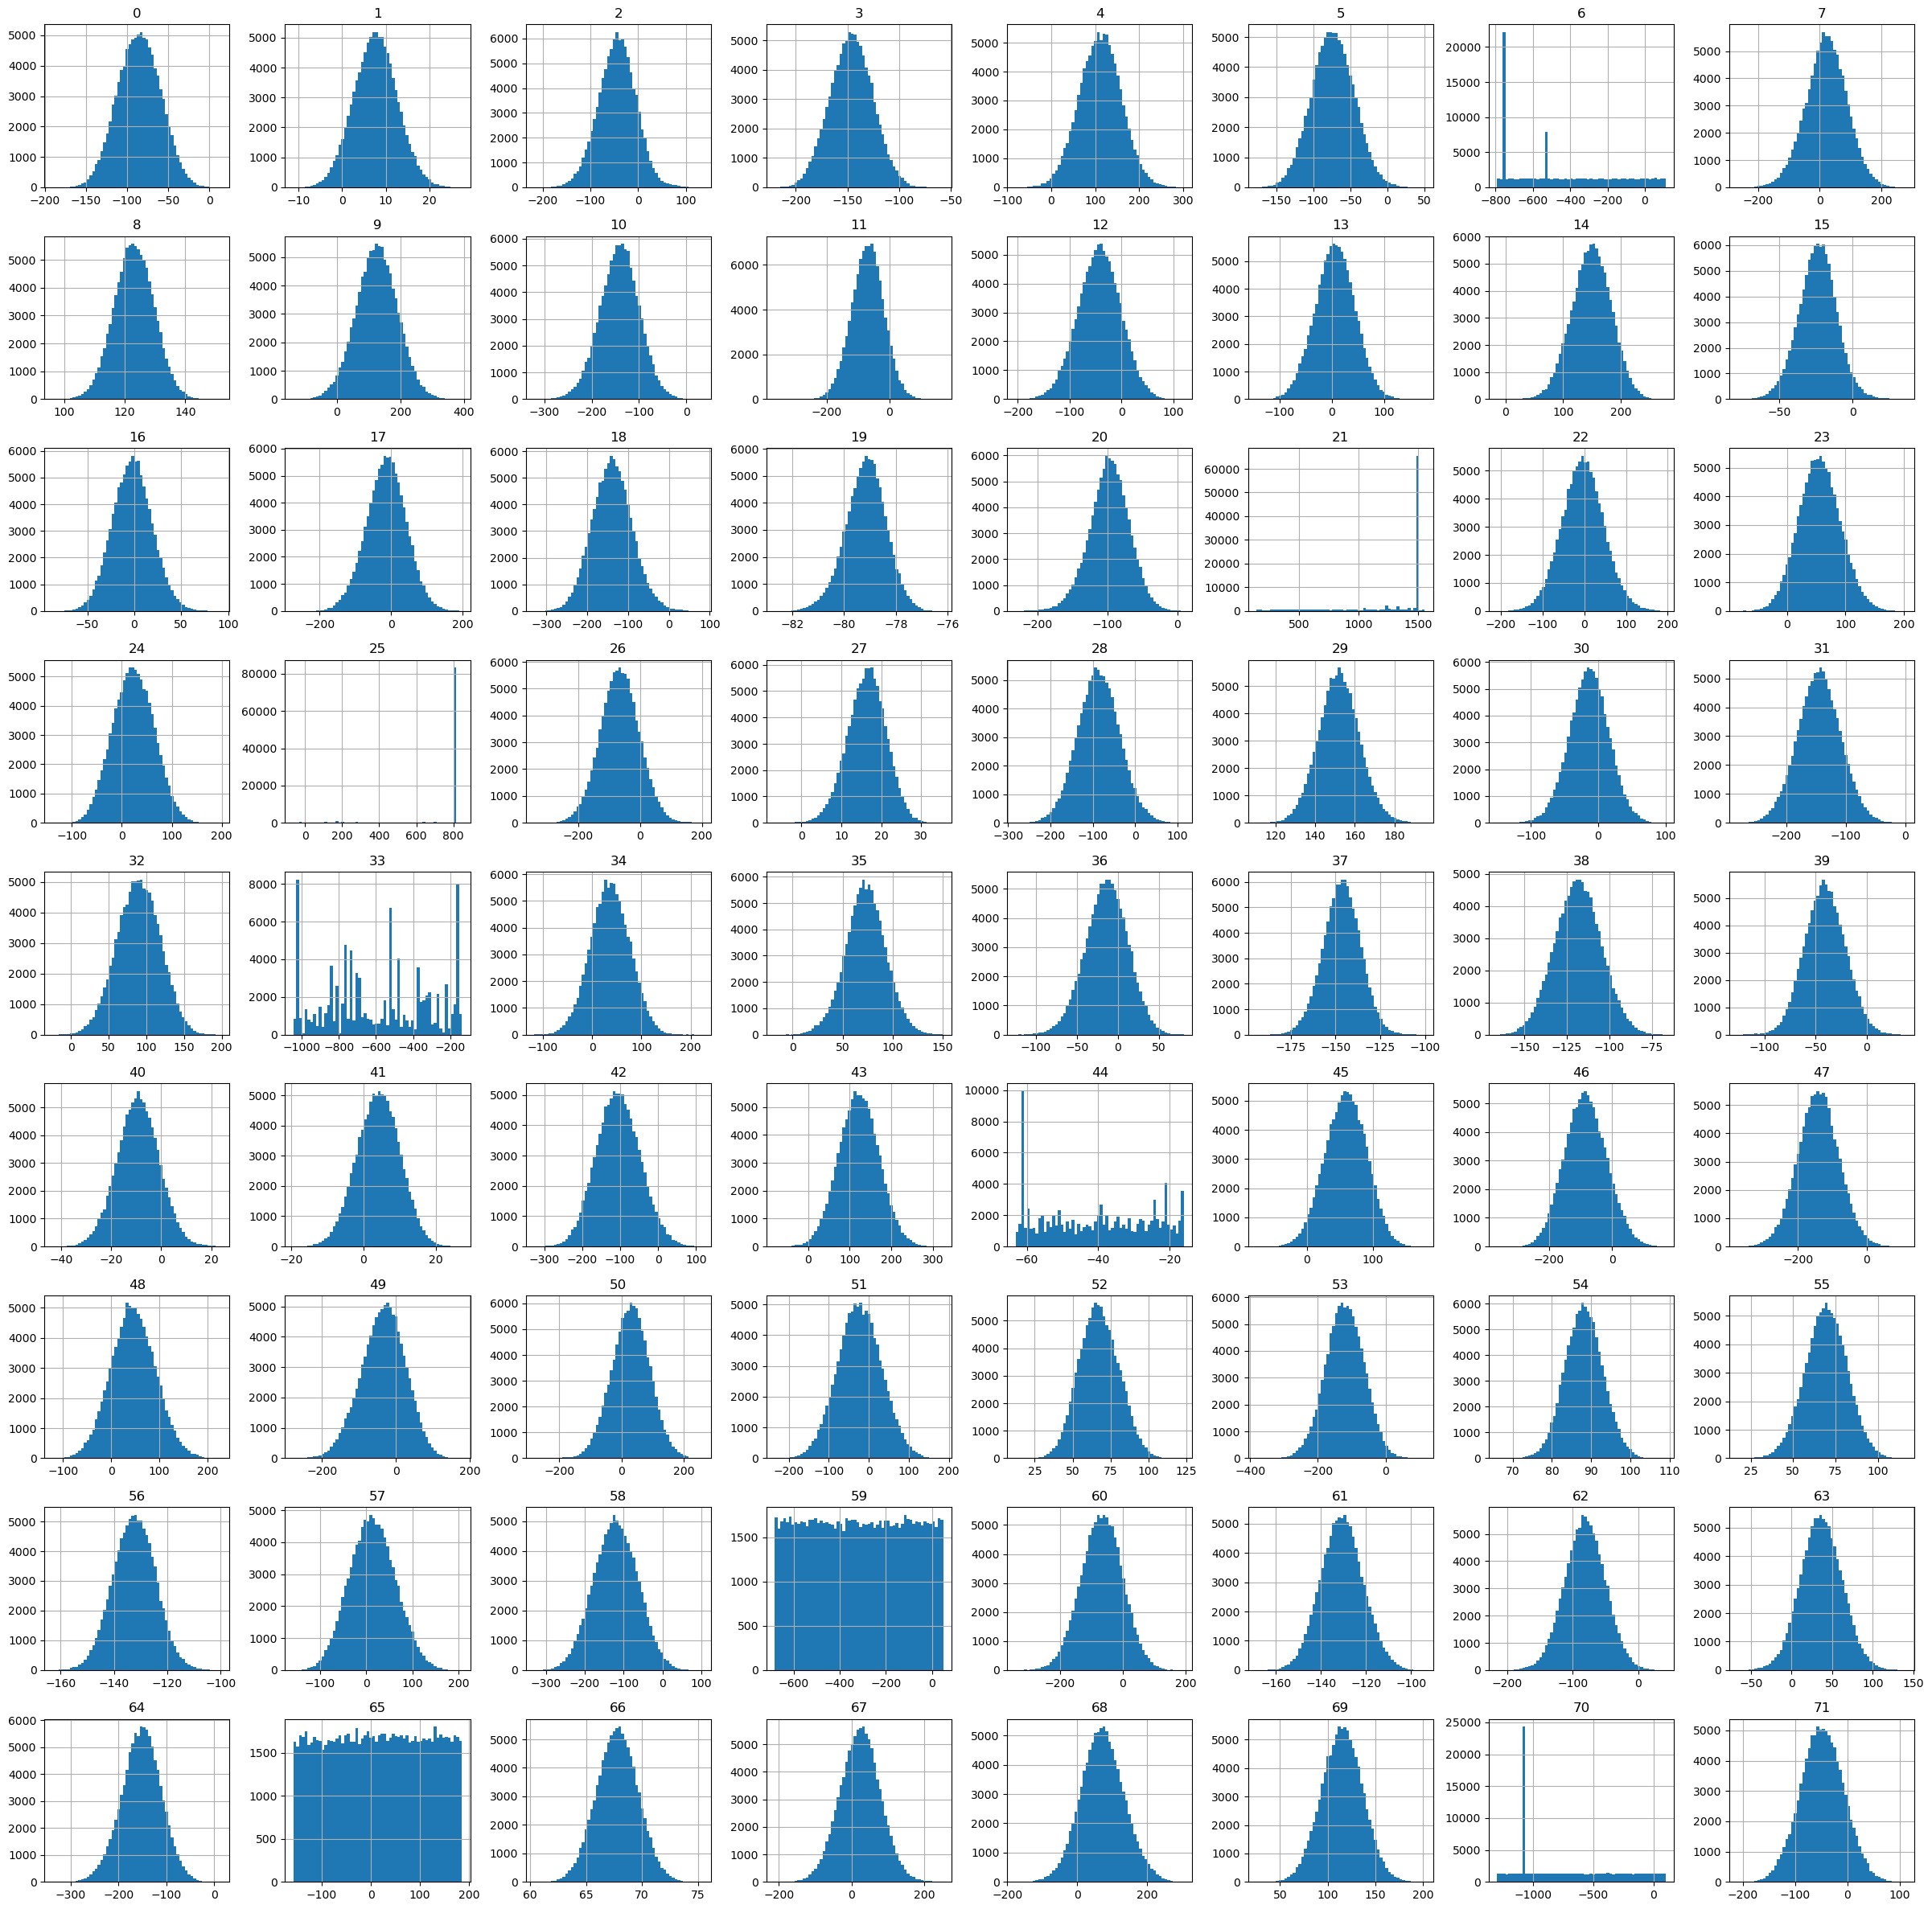

In [20]:
# Смотрим на распределение всех признаков датасета valid_df
valid_df.hist(figsize=[30, 30], bins=60);

**Вывод по разделу 3: Исследовательский анализ данных (EDA)**

С помощью гистограмм мы посмотрели на распределение всех признаков в каждом датасете. Как результат, мы увидели, что в некоторых признаках распределение не является нормальным, причем одни и те же признаки с ненормальным распределением повторяются во всех датасетах, включая base_df, train_df, valid_df.

Номера признаков в которых отсутствует нормальное распределение: '6', '21', '25', '33', '44', '59', '65', '70'

Принимаем решение, что в следующем разделе проекта работу начнем с удаления этих признаков из всех наборов данных. 

## Подготовка данных

In [21]:
# Удаляем признаки в которых отсутствует нормальное распределение
base_df = base_df.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1)
train_df.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)
valid_df.drop(['6', '21', '25', '33', '44', '59', '65', '70'], axis=1, inplace=True)

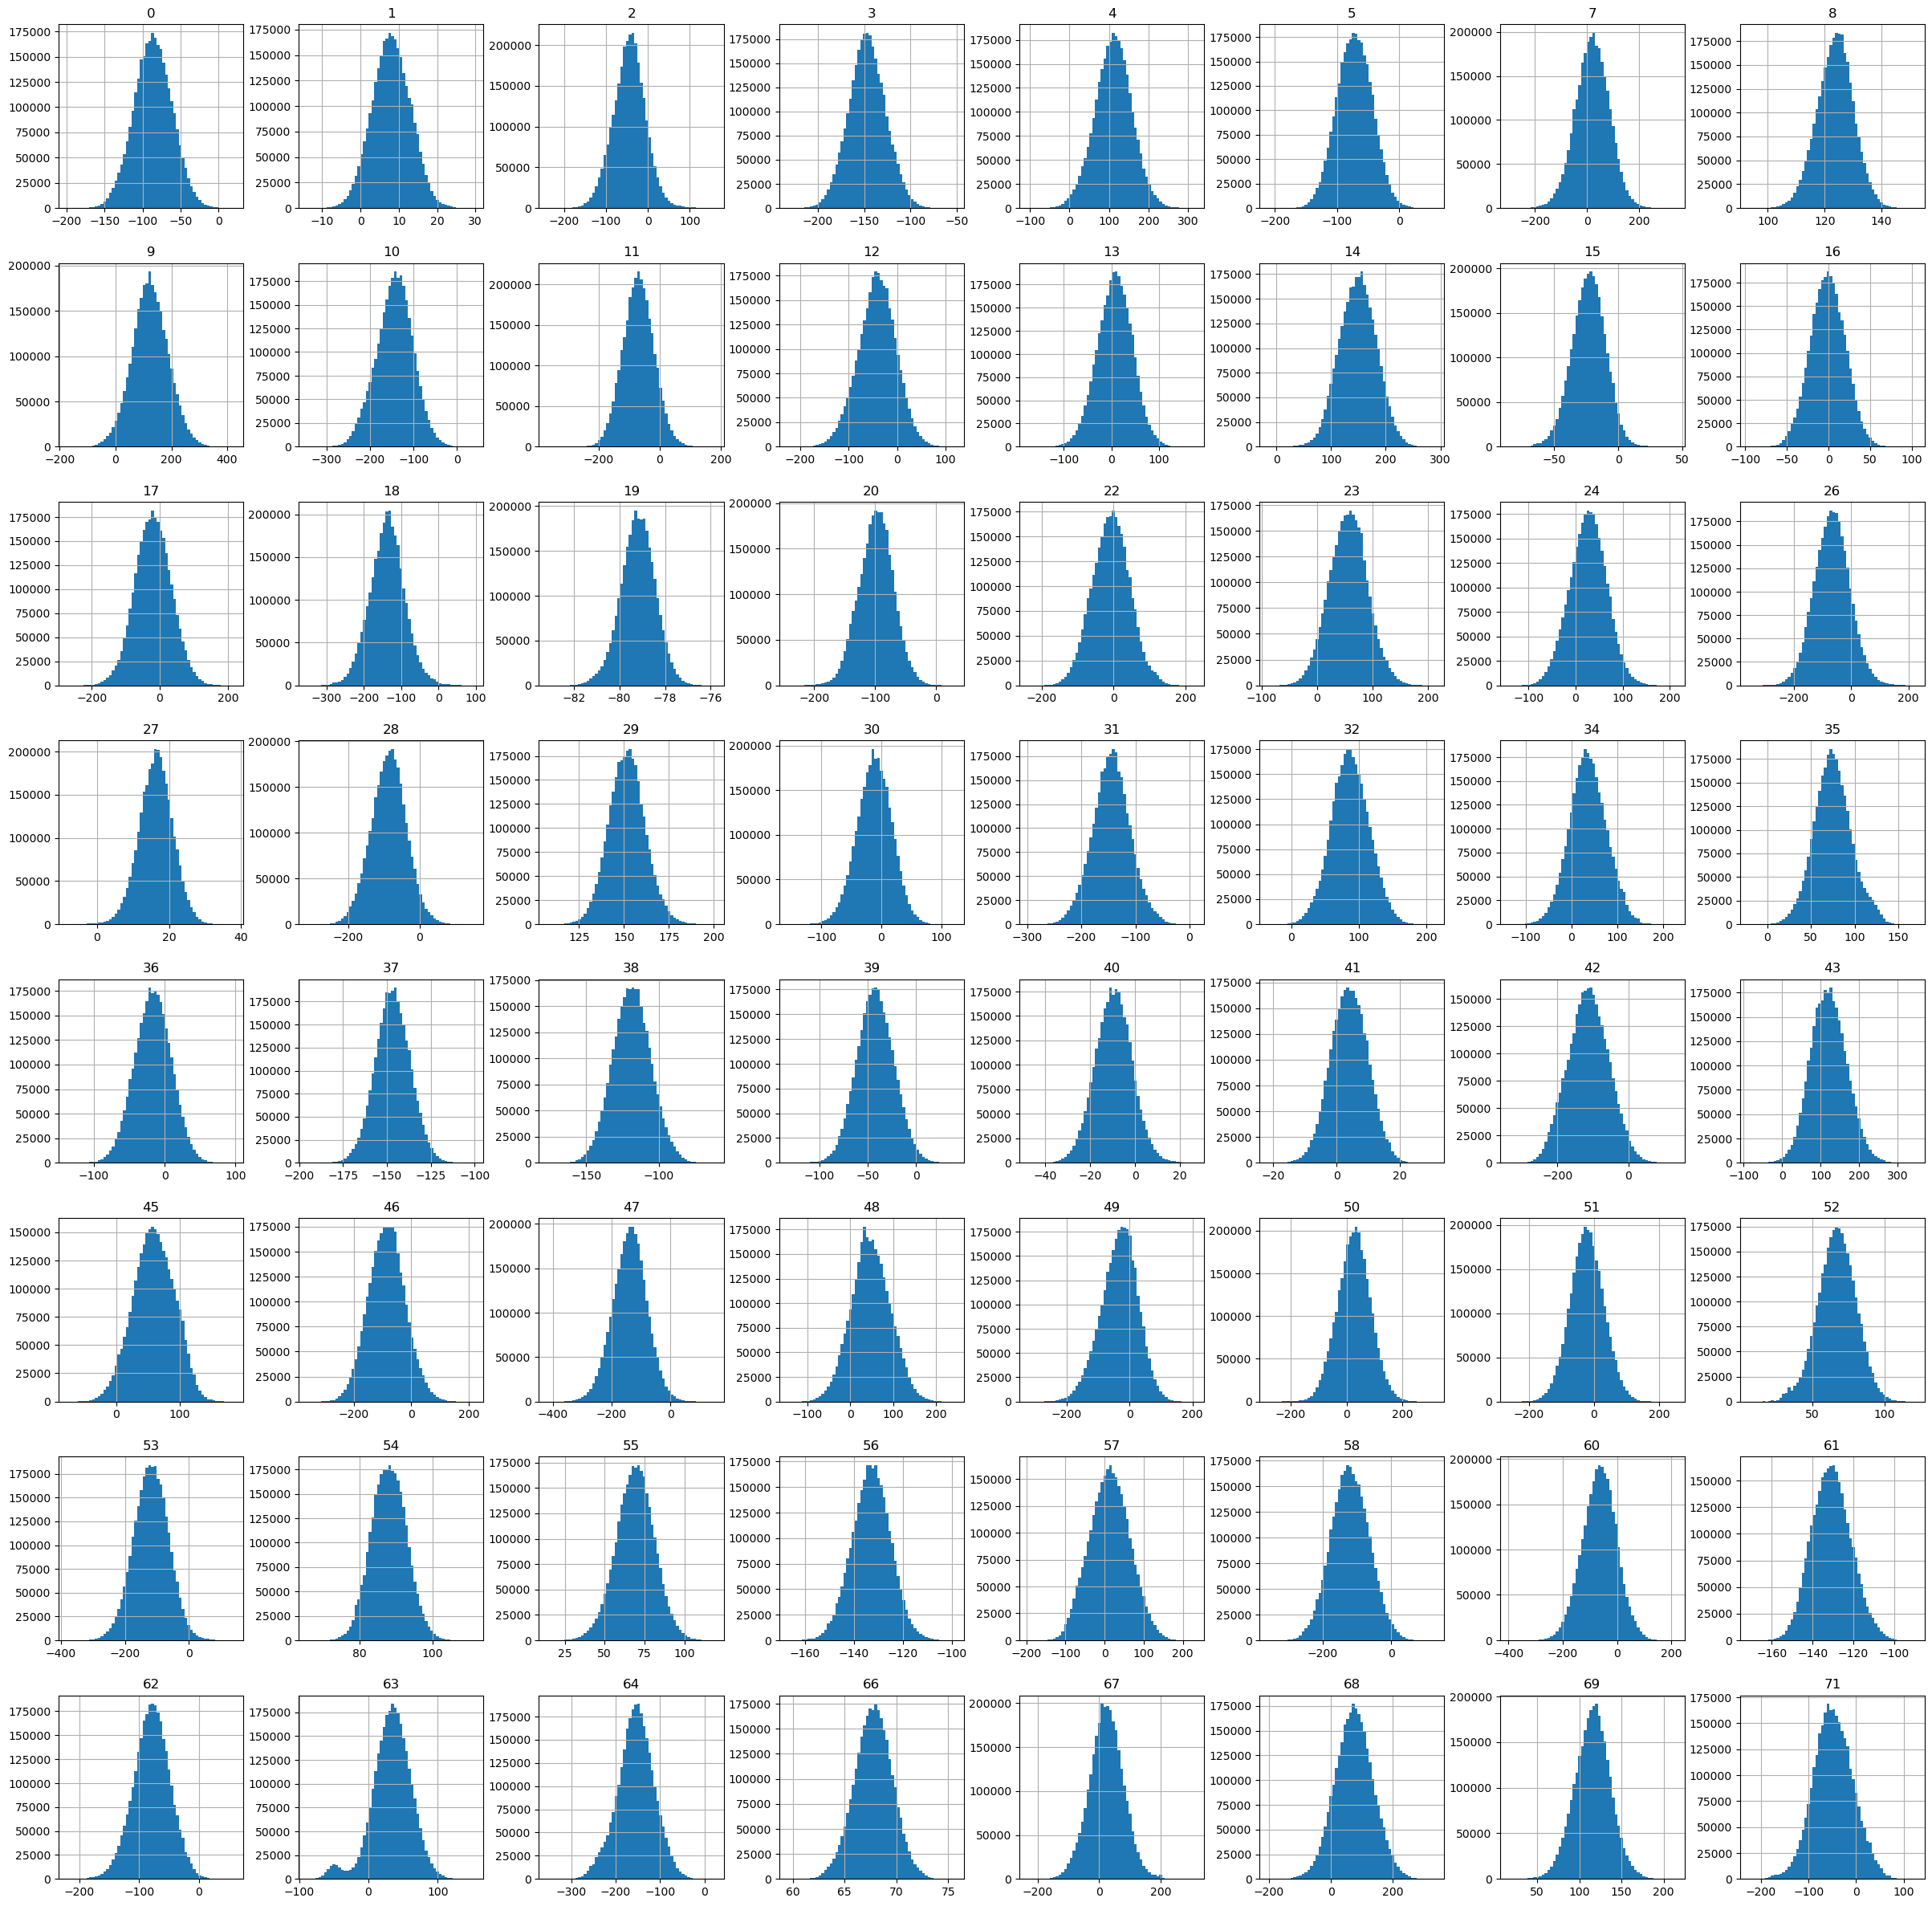

In [22]:
# Проверяем сделанные преобразования в датасете base_df
base_df.hist(figsize=[30, 30], bins=60);

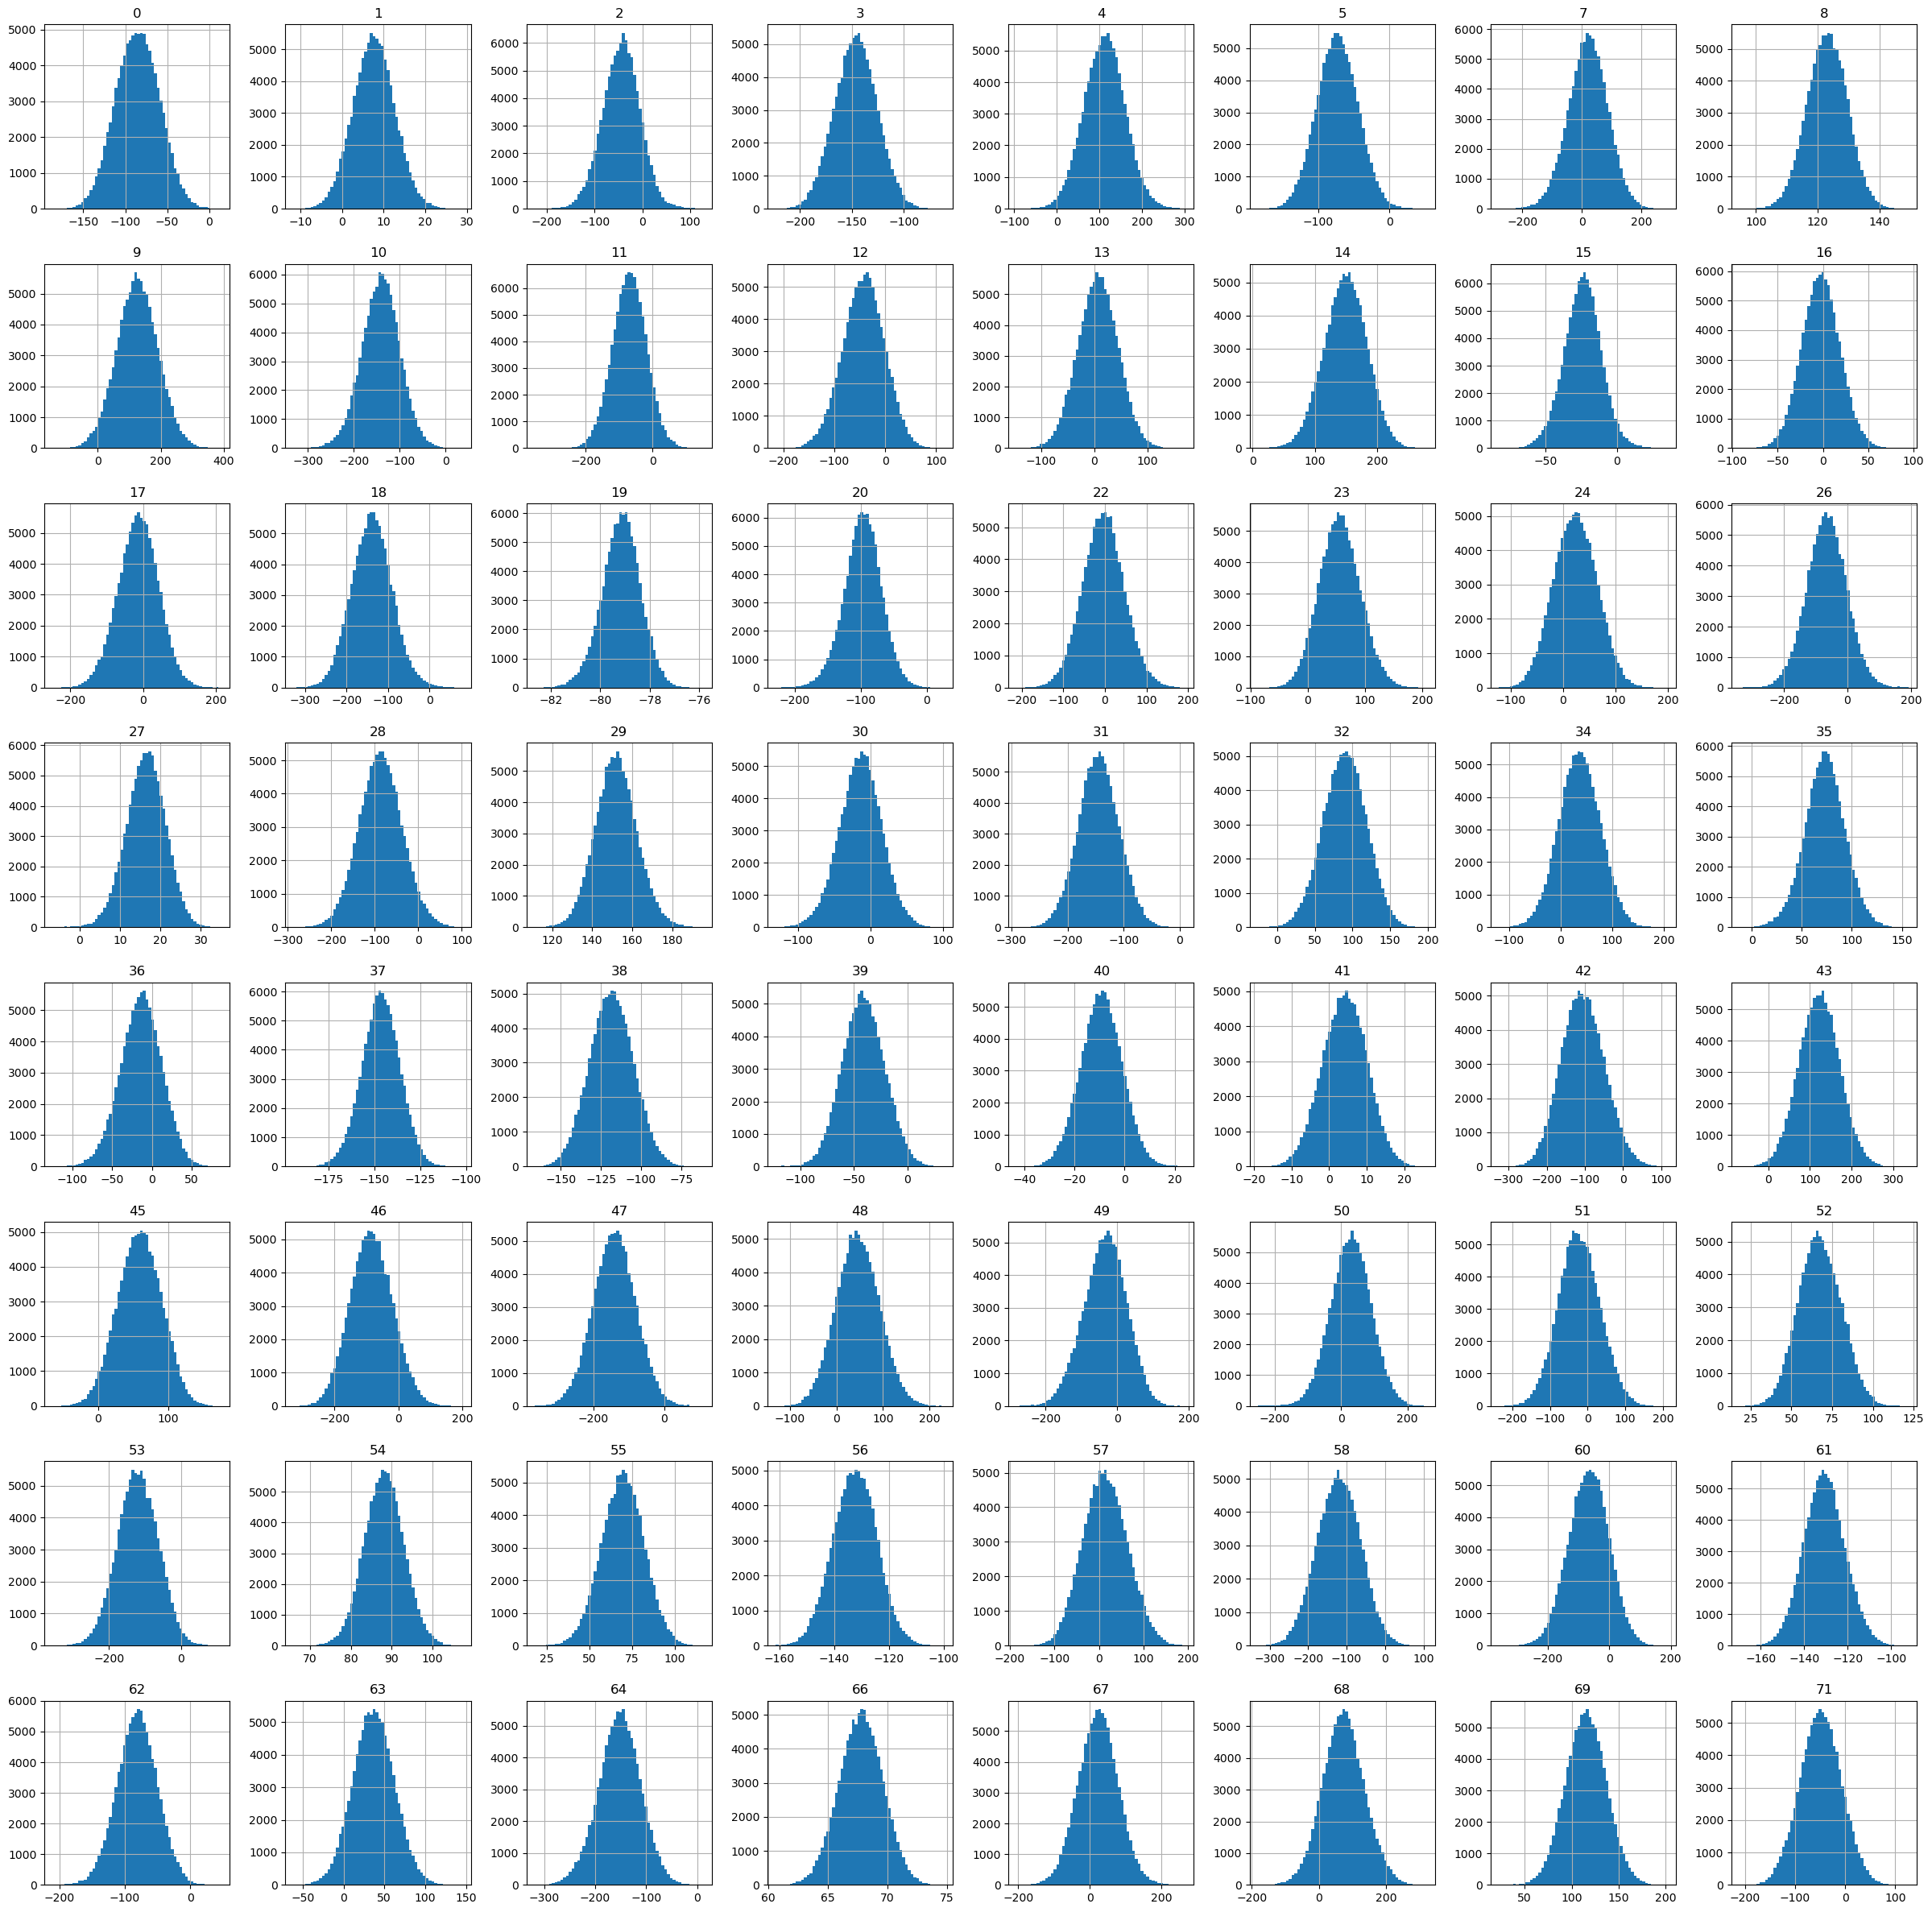

In [23]:
# Проверяем сделанные преобразования в датасете train_df
train_df.hist(figsize=[30, 30], bins=60);

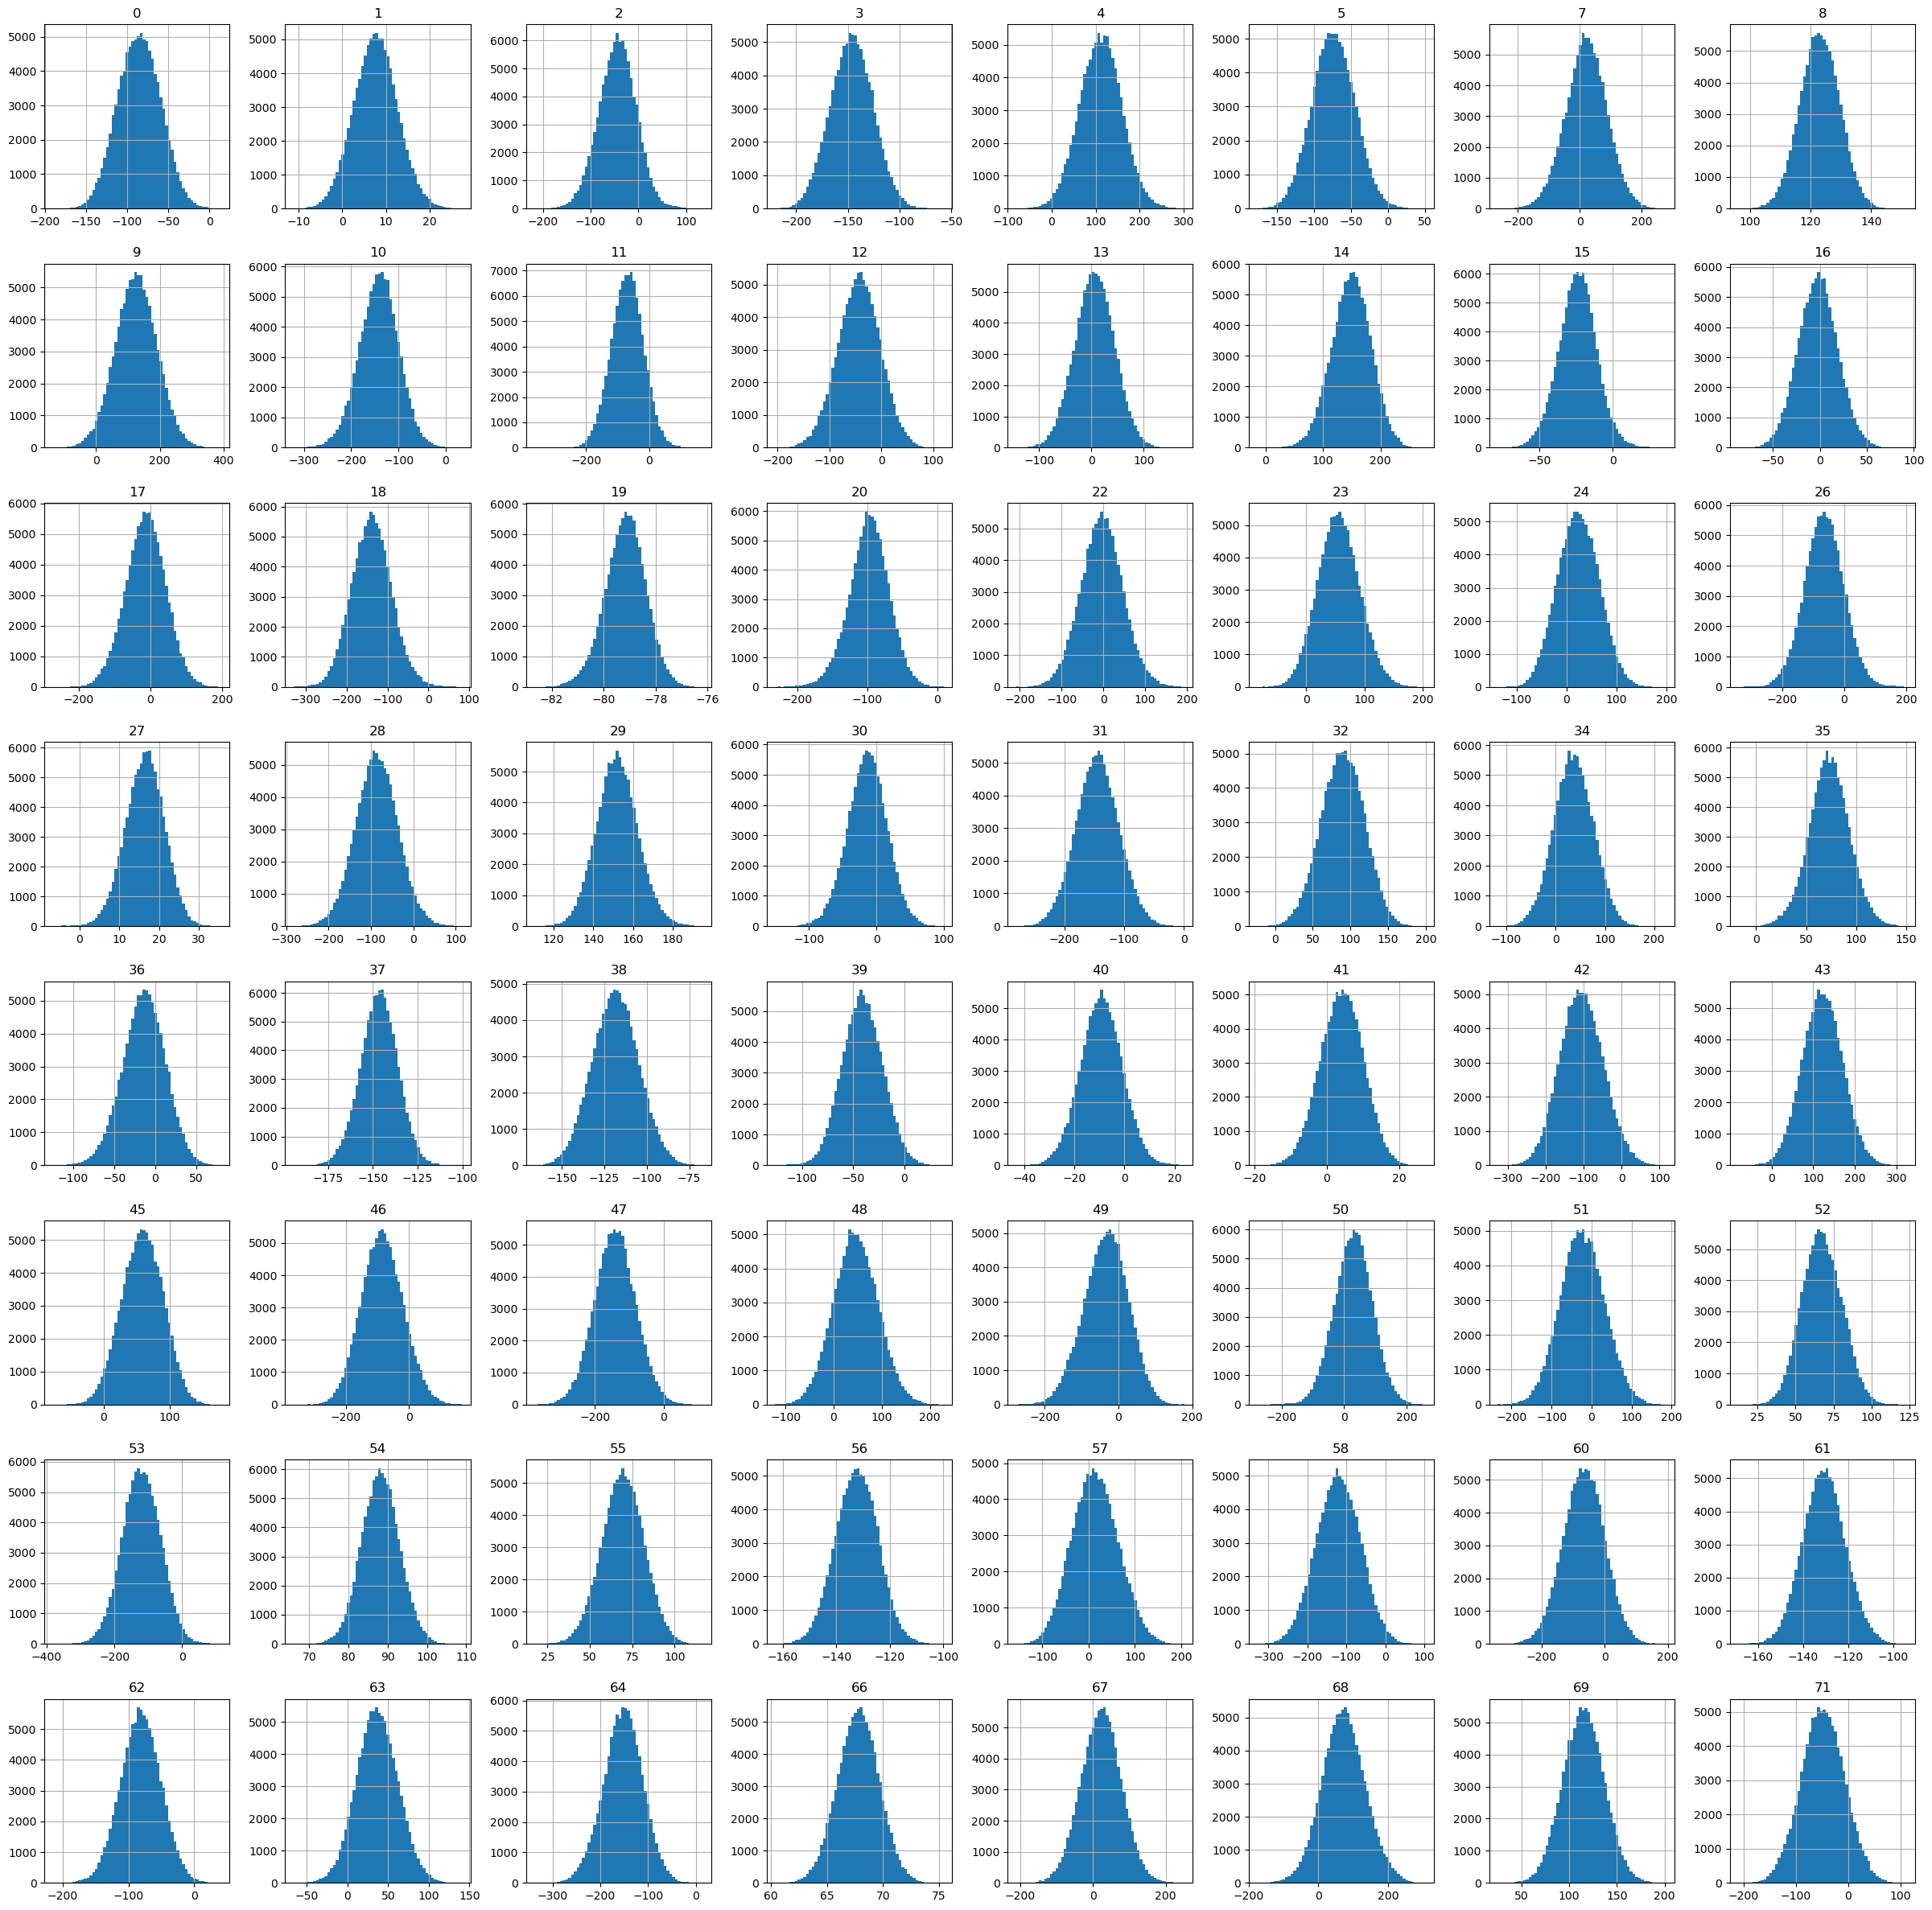

In [24]:
# Проверяем сделанные преобразования в датасете valid_df
valid_df.hist(figsize=[30, 30], bins=60);

In [25]:
# Также, смотрим на размерность датасетов методом shape
print(base_df.shape)
print(train_df.shape)
print(valid_df.shape)
print(valid_targets.shape)

(2918139, 64)
(100000, 65)
(100000, 64)
(100000, 1)


In [26]:
# Определяем признаки для обучения, а также отделяем целевой признак из обучающей выборки
train_targets = train_df['target']
train_df.drop('target', axis=1, inplace=True)

In [27]:
# Смотрим на размерность датасетов методом shape
print(base_df.shape)
print(train_df.shape)
print(valid_df.shape)
print(valid_targets.shape)

(2918139, 64)
(100000, 64)
(100000, 64)
(100000, 1)


### Шкалирование данных

In [28]:
# Производим шкалирование данных с помощью функции StandardScaler
scaler = StandardScaler()
scaler.fit(base_df)
base_transform  = scaler.transform(base_df)
train_transform = scaler.transform(train_df)
valid_transform = scaler.transform(valid_df)

# Выводим примеры преобразованных векторов
print('base:\n',  base_transform[0],  '\n')
print('train:\n', train_transform[0], '\n')
print('valid:\n', valid_transform[0], '\n')

base:
 [-1.1592164   0.6203504  -0.5137226   1.3985578   2.2690434  -1.160385
  0.37366256 -0.43562654  0.8845438   0.45764694  0.73073906 -0.41463423
  0.78201586  1.0028546  -0.37510103 -0.20510186  0.33189055  0.9904282
 -0.3661679  -0.20190129 -0.49577627 -0.15306659 -2.0184343   0.4013575
 -1.695555   -0.89876324 -0.29430768  0.05313913  0.03532424 -0.26462495
 -0.8388547   1.693444    0.80234647 -0.6729527  -0.38906187  0.11310667
 -0.40123945 -1.4086897  -0.706407   -0.96219635 -1.2977861  -0.22126234
  0.00696119  0.9529049  -2.3730829  -1.2994182   1.575435    0.84989077
  0.52136797  0.28986818  0.88773793  0.43401998 -1.1332438   0.7088193
  0.00679184 -0.847513    1.1890489   0.19052392  0.07358862 -2.2624936
 -0.51043767  0.29300365 -0.0140508  -0.31232867] 

train:
 [ 1.2995185   1.9968883   0.06377415 -1.8796704   1.6440995  -0.53762573
  0.27959806 -2.2967937  -1.4596262   1.3207101   0.33563283  0.34833786
 -0.074182    1.4675779  -0.52832973 -0.13761893 -2.1992238  -0

## Поиск ближайших соседей с использованием библиотеки faiss

Модуль faiss - это разработка команды Facebook AI Research для быстрого поиска ближайших соседей и кластеризации в векторном пространстве.

Первым шагом нам необходимо создать словарь для сопоставления порядкового номера векторов, поскольку faiss в процессе деления данных на кластеры и поиска их центроидов преобразует набор данных в двумерный массив после чего данные потеряют свои уникальные id.

In [29]:
# Создаем словарь id и номеров векторов
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}

print('Пример словаря:\n', list(base_index.items())[0:5])

Пример словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base'), (3, '3-base'), (4, '4-base')]


Следующим шагом мы должны инициализировать квантизатор (Quantizer) и измерение расстояния (Dimensions).

In [30]:
dimensions = base_transform.shape[1]

quantizer = faiss.IndexFlatL2(dimensions)
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, N_CLUSTERS)

В нашем подходе используется IndexFlatL2 для точного поиска ближайших соседей с использованием L2 (евклидового) расстояния, а IndexIVFFlat - это инвертированный файловый индекс с плоским квантователем, который полезен для крупномасштабного поиска.

idx_l2 представляет собой пространство векторов размерностью dimensions, которое разбито на определенное количество кластеров, состоящих из N_CLUSTERS, с использованием quantizer.

Следующим шагом мы будем обучать модель делителя пространства и делить все векторы на кластеры 

In [31]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(base_transform[:50000, :]).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(base_transform).astype('float32'))

В нашем обучении делителя и делении вектора мы используем функцию np.ascontiguousarray, которая размещает в памяти непрерывный массив данных.

Следующим шагом происходит поиск ближайших соседей для каждого вектора в train_transform по индексу idx_l2. Как результат мы получим два массива: distance содержит расстояния до ближайших соседей, а train_idx - индексы ближайших соседей.

In [32]:
# Производим поиск ближайших соседей
distance, train_idx = idx_l2.search(np.ascontiguousarray(train_transform).astype('float32'), K_NEIGHBORS)

print('Примеры train_idx :\n', train_idx[:3], '\n')
print('Примеры vectors :\n', distance[:3])

# Оптимизируем память и удаляем массив distance
del distance

Примеры train_idx :
 [[ 336969 1113711 1818641  480296  232405 2360257 2295048  454434  755584
    89840 1136231  598613  629775 1037661  143978 1307670 1653095  142730
   503716 1375244  792610 1472986  352715 1646333 2356601   13374  455829
  1142019 2479662  960901 2339134  323974 1299775  816981  986050 2145555
   583287 1639495 1674977 1598432 2054647  988777   49353 2711635  845854
  1224144  622880 1934845  728097  854264 1747988  547719 1409261 1159463
  1374819  382333 1631947   58509  851029 2700063 1285249  233844  629636
   682218  703484  400676  445520  450667  223859   57113  443428 2331892
   271665 2531948  200263  669932  438404 1324342  751217  994711  458465
   105660 1546520  264577 1394044  914354 2042379 2186758 2398299 1397253
  2346335 1148466 2784306  453252 2212973  803577  199196 2367699 1746258
   108138]
 [  15185  223456 2524968  902634  464427 2584784  311357 2469267 1252594
  2151558  124343  295462 1012984   51220 1325497 1007827  781791 1238630
  1149

Следующим шагом вычисляем метрику accuracy@n

### Вычисление метрики Accuracy

In [33]:
# функция вычисления accuracy@n
def accuracy_n(targets, predict, base_index=base_index):
    acc = 0
    for target, candidates in zip(targets.tolist(), predict.tolist()):
        acc += int(target in [base_index[number] for number in candidates])

    return (acc / len(predict) * 100)

In [34]:
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(train_targets, train_idx)))

accuracy@100: 68.39%


Мы вычислили метрику Accuracy@100

Мы поделили векторное пространство из объектов датасета base на 200 кластеров для ускорения поиска. Для каждого объекта из train были найдены 20 ближайших соседей-векторов при помощи меры FlatL2.
Метрика Accuracy@100 показала результат 63.43%, то есть для 63% новых товаров из датасета train найдено 100 кандидатов для сопоставления.
Следующим шагом нам необходимо определить самый подходящий товар среди найденных кандидатов, поэтому первым делом сделаем сортировку.

### Создание тренировочного датасета

Тренировочный датасет будет состоять из векторов и кандидатов для мэтчинга. Добавим новое поле 'matching', которе будет содержать два варианта ответа, а именно 1 - вектор сопоставим, и 2 - вектор несопоставим.

In [35]:
# Формируем набор данных с ID новых и предыдущих объектов
idx_df = pd.DataFrame(data=train_idx, index=train_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,0-query,361564-base
1,0-query,1375561-base
2,0-query,2515747-base
3,0-query,530165-base
4,0-query,244376-base
...,...,...
9999995,99999-query,3217783-base
9999996,99999-query,1991073-base
9999997,99999-query,868941-base
9999998,99999-query,856415-base


Ранее мы уже производили шкалирование данных. Возьмем их и на их базе объединим данные по полученным полям 'id'.

In [36]:
# Создание датафреймов из масштабированных данных
base_transform_df  = pd.DataFrame(base_transform,  index=base_df.index)
train_transform_df = pd.DataFrame(train_transform, index=train_df.index)
valid_transform_df = pd.DataFrame(valid_transform, index=valid_df.index)

# Объединение base и train по id
train_base_df = idx_df.merge(train_transform_df, left_on='id_query', right_on='id', how='left')
train_base_df = train_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
train_base_df = train_base_df.merge(train_targets, left_on='id_query', right_on='id', how='left')
display(train_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base,target
0,0-query,361564-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.216622,-0.332150,1.723392,-0.369458,-1.100242,0.280916,-0.492041,0.532096,0.090279,675816-base
1,0-query,1375561-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.144493,-0.873146,1.699855,-0.241953,-0.985258,0.009024,-0.475138,0.479393,0.371489,675816-base
2,0-query,2515747-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,-0.220597,-0.673620,1.182057,-0.393427,-1.039616,0.076838,-0.353940,0.698070,0.920024,675816-base
3,0-query,530165-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.235215,-0.795016,1.797431,-0.348638,-1.220347,0.203649,-0.711434,0.745986,0.805135,675816-base
4,0-query,244376-base,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,...,0.019230,-0.434846,1.927876,-0.618656,-1.117569,0.592058,-0.571596,0.614138,0.177648,675816-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,99999-query,3217783-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-1.174466,-0.141156,-0.920945,0.798702,-0.027477,1.195041,1.108308,0.324418,-0.723201,2769109-base
9999996,99999-query,1991073-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-0.920680,-0.955784,-1.731923,-0.779645,-0.325241,0.841805,3.135410,-0.507390,0.131387,2769109-base
9999997,99999-query,868941-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-1.321786,-1.345402,-1.221691,-0.069518,-0.804921,1.579994,1.344609,-0.363146,0.515214,2769109-base
9999998,99999-query,856415-base,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,...,-0.570112,0.194392,-1.839040,-0.586670,0.625423,1.688430,1.834324,0.286930,-0.246839,2769109-base


In [37]:
# Формирование целевого признака для бинарной классификации
train_base_df['matching'] = (train_base_df['id_candidate'] == train_base_df['target']).astype('int')
display(train_base_df[['id_query', 'id_candidate', 'target', 'matching']])
train_base_df.drop('target', axis=1, inplace=True)

,id_query,id_candidate,target,matching
0,0-query,361564-base,675816-base,0
1,0-query,1375561-base,675816-base,0
2,0-query,2515747-base,675816-base,0
3,0-query,530165-base,675816-base,0
4,0-query,244376-base,675816-base,0
...,...,...,...,...
9999995,99999-query,3217783-base,2769109-base,0
9999996,99999-query,1991073-base,2769109-base,0
9999997,99999-query,868941-base,2769109-base,0
9999998,99999-query,856415-base,2769109-base,0


In [38]:
# Определение обучающих признаков и отделение целевого признака для обучения
y_train = train_base_df['matching']
X_train = train_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_train.to_frame())
display(X_train)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
9999995,0
9999996,0
9999997,0
9999998,0


,0,1,2,3,4,5,6,7,8,9,...,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base
0,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.414040,0.216622,-0.332150,1.723392,-0.369458,-1.100242,0.280916,-0.492041,0.532096,0.090279
1,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.685312,0.144493,-0.873146,1.699855,-0.241953,-0.985258,0.009024,-0.475138,0.479393,0.371489
2,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.367851,-0.220597,-0.673620,1.182057,-0.393427,-1.039616,0.076838,-0.353940,0.698070,0.920024
3,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.562718,0.235215,-0.795016,1.797431,-0.348638,-1.220347,0.203649,-0.711434,0.745986,0.805135
4,1.299518,1.996888,0.063774,-1.879670,1.644099,-0.537626,0.279598,-2.296794,-1.459626,1.320710,...,0.384374,0.019230,-0.434846,1.927876,-0.618656,-1.117569,0.592058,-0.571596,0.614138,0.177648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,2.124884,-1.174466,-0.141156,-0.920945,0.798702,-0.027477,1.195041,1.108308,0.324418,-0.723201
9999996,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,0.761775,-0.920680,-0.955784,-1.731923,-0.779645,-0.325241,0.841805,3.135410,-0.507390,0.131387
9999997,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,-0.162737,-1.321786,-1.345402,-1.221691,-0.069518,-0.804921,1.579994,1.344609,-0.363146,0.515214
9999998,-0.113252,0.577083,-0.223273,0.123277,0.693205,-0.521279,0.885642,-0.902250,-0.794043,-0.111113,...,0.240775,-0.570112,0.194392,-1.839040,-0.586670,0.625423,1.688430,1.834324,0.286930,-0.246839


Следующим шагом повторим подход поиска ближайших соседей, но уже для валидационной выборки, а также расчитаем метрику Accuracy@100.

In [39]:
# Производим поиск ближайших соседей для валидационной выборки
vectors, valid_idx = idx_l2.search(np.ascontiguousarray(valid_transform), K_NEIGHBORS)

print('Примеры idx :\n', valid_idx[:3], '\n')
print('accuracy@{}: {:.2f}%'.format(K_NEIGHBORS, accuracy_n(valid_targets['expected'], valid_idx)))

# Оптимизируем память
del vectors

Примеры idx :
 [[1954150 2192372 1225777 2504096  462353  999102  342838  340288 1719453
   814942 1037237 2363873 2177660 1405698  106841  518200  369979  536120
  2536973 2875559 2546410 2512787 1952068  574649 1243148  277780 2910875
  1660795   61198 1595615 1359889  778488 1798988 1508869 1566084 1520306
  1837653 2571634 2375158 2886161  270881 2239161 1848744 1833780 1781035
  1869523  995930  406458 1062370  654095 1071999 2126015 2798620  218150
  1548312 1166095  231615 1427159 2496318  382712 2664485  647320 2560782
   925319  571514 2065003  853629  321520 1629865  765419 1169959  393929
  2358770 1626118 1959460  111466 2064320 1908173 2508079 2864232 2521726
  2005270  160457 2366011 1627585 1387472 1006654 2519148  615345 1500590
   293614 2096070  331374 1655592 2779479  667204 2392242  876206  973947
   811899]
 [1034632 1478916 2774172  876975 1257658 2520269   43080 1459775  836529
   786415 1517808  771210  883247 2096879   87184 1494606 2142279 2185698
   945049 21

In [40]:
# Формируем набор данных с ID новых и предыдущих объектов
idx_df = pd.DataFrame(data=valid_idx, index=valid_df.index)
idx_df = pd.melt(idx_df.T)
idx_df.columns = ['id_query', 'candidate']
idx_df['id_candidate'] = [base_index[number] for number in idx_df['candidate'].values]
idx_df.drop('candidate', axis=1, inplace=True)

display(idx_df)

,id_query,id_candidate
0,100000-query,2760762-base
1,100000-query,3209652-base
2,100000-query,1542803-base
3,100000-query,3839597-base
4,100000-query,508555-base
...,...,...
9999995,199999-query,2897894-base
9999996,199999-query,3478412-base
9999997,199999-query,2155212-base
9999998,199999-query,1145854-base


In [41]:
# Объединяем base и valid по списку ближайших соседей
valid_base_df = idx_df.merge(valid_transform_df, left_on='id_query', right_on='id', how='left')
valid_base_df = valid_base_df.merge(base_transform_df, left_on='id_candidate', right_on='id', how='left', suffixes=('', '_base'))
valid_base_df = valid_base_df.merge(valid_targets, left_on='id_query', right_on='id', how='left')
display(valid_base_df)

,id_query,id_candidate,0,1,2,3,4,5,6,7,...,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base,expected
0,100000-query,2760762-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.578071,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162420,-1.245106,2676668-base
1,100000-query,3209652-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.929757,0.457505,0.948873,0.570802,0.909869,0.897679,0.018913,0.430446,-1.182590,2676668-base
2,100000-query,1542803-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.539853,0.112325,0.345714,0.193005,0.721656,0.610940,-0.160718,0.507207,-1.025508,2676668-base
3,100000-query,3839597-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.979324,0.247559,0.610572,-0.253008,0.633808,0.570935,-0.031723,0.628662,-1.195790,2676668-base
4,100000-query,508555-base,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,...,-1.859637,0.304085,0.202567,0.075604,1.019881,0.701631,0.580178,0.301698,-0.860531,2676668-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,199999-query,2897894-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,-0.634953,0.936689,-0.441625,-1.004843,-1.553766,-1.249945,-0.011134,1.213224,-0.605314,336472-base
9999996,199999-query,3478412-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,0.987698,-0.836464,-0.314983,0.018768,-0.615194,0.128949,0.853558,0.408369,-1.151090,336472-base
9999997,199999-query,2155212-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,1.171067,-0.895843,-0.497950,-0.552125,-0.511002,-0.560127,0.188231,1.251355,-0.528400,336472-base
9999998,199999-query,1145854-base,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,...,-0.097900,-0.776409,-0.101540,-0.693862,-0.867057,-0.443488,0.623426,0.981481,-1.015418,336472-base


In [42]:
# Формирование целевого признака для бинарной классификации
valid_base_df['matching'] = (valid_base_df['id_candidate'] == valid_base_df['expected']).astype('int')
display(valid_base_df[['id_query', 'id_candidate', 'expected', 'matching']])
valid_base_df.drop('expected', axis=1, inplace=True)

,id_query,id_candidate,expected,matching
0,100000-query,2760762-base,2676668-base,0
1,100000-query,3209652-base,2676668-base,0
2,100000-query,1542803-base,2676668-base,0
3,100000-query,3839597-base,2676668-base,0
4,100000-query,508555-base,2676668-base,0
...,...,...,...,...
9999995,199999-query,2897894-base,336472-base,0
9999996,199999-query,3478412-base,336472-base,0
9999997,199999-query,2155212-base,336472-base,0
9999998,199999-query,1145854-base,336472-base,0


In [43]:
# Определение обучающих признаков и отделение целевого признака для обучения
y_valid = valid_base_df['matching']
X_valid = valid_base_df.drop(['id_query', 'id_candidate', 'matching'] , axis=1)

display(y_valid.to_frame())
display(X_valid)

,matching
0,0
1,0
2,0
3,0
4,0
...,...
9999995,0
9999996,0
9999997,0
9999998,0


,0,1,2,3,4,5,6,7,8,9,...,54_base,55_base,56_base,57_base,58_base,59_base,60_base,61_base,62_base,63_base
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.511698,-1.578071,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162420,-1.245106
1,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.655191,-1.929757,0.457505,0.948873,0.570802,0.909869,0.897679,0.018913,0.430446,-1.182590
2,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.979234,-1.539853,0.112325,0.345714,0.193005,0.721656,0.610940,-0.160718,0.507207,-1.025508
3,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.608282,-1.979324,0.247559,0.610572,-0.253008,0.633808,0.570935,-0.031723,0.628662,-1.195790
4,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.380106,-1.859637,0.304085,0.202567,0.075604,1.019881,0.701631,0.580178,0.301698,-0.860531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,0.687059,-0.634953,0.936689,-0.441625,-1.004843,-1.553766,-1.249945,-0.011134,1.213224,-0.605314
9999996,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,0.706899,0.987698,-0.836464,-0.314983,0.018768,-0.615194,0.128949,0.853558,0.408369,-1.151090
9999997,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,0.571800,1.171067,-0.895843,-0.497950,-0.552125,-0.511002,-0.560127,0.188231,1.251355,-0.528400
9999998,1.826818,-0.251821,0.377601,-0.487494,-0.053289,0.448831,-0.978521,-0.659733,-1.092404,0.018027,...,1.144470,-0.097900,-0.776409,-0.101540,-0.693862,-0.867057,-0.443488,0.623426,0.981481,-1.015418


## Обучение модели и расчет метрики Accuracy@5

Для обучения модели мы выбрали CatBoostClassifier. Зададим параметр iterations как 15 для градиентного бустинга.

In [44]:
# Импортируем модель
from catboost import CatBoostClassifier

# Инициируем модуль
model = CatBoostClassifier(iterations=15, random_state=RANDOM_STATE)

In [45]:
# Обучаем модель и формируем предсказания
model.fit(X_train, y_train)
valid_predictions = model.predict(X_valid)
valid_probabilities = model.predict_proba(X_valid)[:, 1]

Learning rate set to 0.5
0:	learn: 0.0967028	total: 2.55s	remaining: 35.7s
1:	learn: 0.0490515	total: 4.59s	remaining: 29.9s
2:	learn: 0.0407765	total: 6.86s	remaining: 27.4s
3:	learn: 0.0387557	total: 9s	remaining: 24.7s
4:	learn: 0.0368143	total: 10.9s	remaining: 21.9s
5:	learn: 0.0350303	total: 13.1s	remaining: 19.7s
6:	learn: 0.0346739	total: 15.1s	remaining: 17.3s
7:	learn: 0.0336184	total: 16.9s	remaining: 14.8s
8:	learn: 0.0325109	total: 19.1s	remaining: 12.8s
9:	learn: 0.0315437	total: 21s	remaining: 10.5s
10:	learn: 0.0305196	total: 22.8s	remaining: 8.28s
11:	learn: 0.0297014	total: 24.4s	remaining: 6.11s
12:	learn: 0.0289684	total: 26.2s	remaining: 4.03s
13:	learn: 0.0283324	total: 28.1s	remaining: 2.01s
14:	learn: 0.0275528	total: 30s	remaining: 0us


In [46]:
# Подбираем 5 наиболее подходящих кандидатов для сопоставления
valid_proba_series = pd.Series(valid_probabilities)

valid_candidates = []
for i in range(0, len(valid_proba_series), K_NEIGHBORS):
    query = valid_proba_series[i : i+K_NEIGHBORS]
    index = query.sort_values(ascending=False)[0:N_CELLS].index
    valid_candidates.append(index)

# Выводим полученный результат
print('Кол-во предсказаний:', len(valid_candidates))
print('Кол-во кандидатов:', len(valid_candidates[0]))

Кол-во предсказаний: 100000
Кол-во кандидатов: 5


In [47]:
# Расчитываем метрику Aсcuracy@5
acc = 0
for target, candidates in zip(valid_targets.values.tolist(), valid_candidates):
    acc += int(target in valid_base_df.loc[candidates, 'id_candidate'].values)

print('valid_accuracy@{}: {:.2f}%'.format(N_CELLS, acc / len(valid_candidates) * 100))

valid_accuracy@5: 51.41%


**ВЫВОД**

В ходе выполнения проекта были выполнены следующие шаги:

**1. Загрузка требуемых библиотек**

**2. Чтение данных, включая:**
 - смену типа данных с float64 на float32
 - сброс индексации
 
**3. Исследовательский анализ данных (EDA), включая:**
 - Изучение признаков с помощью гистограмм 
 - Анализ распределения признаков всех наборов данных
 - Проверка наличия пропусков и дубликатов
 
**4. Подготовка данных, включая:**
 - Удаление признаков в которых отсутствует нормальное распределение
 - Шкалирование данных
 
**5. Поиск ближайших соседей с помощью библиотеки FAISS**
 - Разбили набор данных base на 20 кластеров
 - получили 20 ближайших векторов (соседей)
 - Получили 20 кандидатов для 68,39% новых товаров из Train среди которых сопоставляется целевой
 
**6. Обучение модели и расчет метрики accuracy@5**
 - Среди найденных сопоставленных товаров было найдено 5 самых ближайших
 - Для этого мы использовали модель CatBoostClassifier
 - Получили метрику Accuracy@5 в 51.41%